# Product Recognition on Store Shelves

**Marco Scaramuzzi** 

- Student ID: 0001057167
- email: marco.scaramuzzi@studio.unibo.it

## Task - Step B - Multiple Instance Detection

Develop a computer vision system that, given a reference image for each product, is able to identify boxes of cereals of different brands from one picture of a store shelf. For each type of product displayed in the shelf the system should report:

1. Number of instances.
2. Dimension of each instance (width and height of the bounding box that enclose them in pixel).

####  Test on scene image: {m1.png, m2.png, m3.png, m4.png, m5.png} 
####  Use product images: {0.jpg, 1.jpg, 11.jpg, 19.jpg, 24.jpg, 25.jpg, 26.jpg} 

**Disclaimer**

In order to provide ease of access and at the same time having a modular project structure only the **relevant** functions were left inside the notebook, others utility functions such as displaying images or drawing bounding boxes are put inside the `image_utils.py` and the `bounding_box.py` files which are located in the `/utils` folder, if there is a need inspect their contents.

In [20]:
#Import required modules

import numpy as np
import cv2
import os
from glob import glob
from collections import defaultdict

# Visualization
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns

# Type annotations
from numpy.typing import NDArray
from typing import Callable, Dict, List, Tuple

# Custom modules
import utils.image_utils as iut
import utils.bounding_box_utils as bb

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 0. Organisation and structure of the notebook

### Organisation

This notebook attemps at solving the `step_B` of the Product Recognition on Store Shelves. In this step the task consist on correctly detecting the presence of a certain brand cereal box in a shelve inside a supermarket. 

- In this second step the problem is posed as a multiple instance detection: 
  Unlike i did for step A, I cannot only exploit `Local Invariant Features` to retrieve at most a single instance for each model in a scene
  - Some additional functions have been added to the previously defined code in order to also be able to detect multiple instance
  - The notebook structure has been preseverved for the sections for the most part in order to ensure coherence between the two steps. 
  - For example the section that deals with the drawing of the bounding boxes and displaying of the instance information has mostly the same structure as before and also the keypoint detections through SIFT is the same as the step_A because they are not influenced by the change in number of instance
  - Also the acquiring of the images has been re-utilized
  - **COMPLETE ME**

#### Computer vision workflow:
1. I utilized SIFT to detect and describe keypoints in the images, employed a k-nearest neighbors (k-NN) search using the FLANN-based matcher for feature matching.
2. Created GHT r-table (excluded rotation for pratical reasons given that cearel boxes are mostly placed in front of the camera with no rotation whatsover or very small rotation)
3. Barycenter research
4. To compute a robust homography i employed the RANSAC algorithm , which enables accurate localization of the detected objects within the scene.

- **COMPLETE HERE**

### Structure

The notebook is structured in N sections:

1. **Data inspection**: In this section there will be a brief assessment what type of data we are dealing with.
2. **Keypoints detection**: In this section By using SIFT descriptors keypoints will be detected in both the scene images and the model images.
3. **Feature matching**: In this section By using FLANN match i will attemp to find a matches by corresponding keypoints between scene and models.
   
4. **Object identification**:  In this section the matches will be filtered in order to keep only true matches between model images and  scene images.
5. **INSERT HERE ADDITIONAL SECTIONS**
6. **Displaying bounding boxes and printing matching coordinates**: In this section all the code from the previous sections will be employed to draw bounding boxes for the matched models and printing their dimensions.
7. **Results computations**: This section will display the results and draw some brief conclusions upon those results. 



## 1. Data inspection

#### Loading and inspecting images

In the cell below we can see the parameter `target_model_dims`, it is a tuple containing the new size that all  that **all** models will have after an operation of resizing. This has been done because the models have different shapes, therefore the function that loads the images will resize the image to a predetermined size if the images are models. This allows to avoid inconsistencies in the detection of the keypoints.

In [21]:
MODEL_REFERENCE_NUM = [0,1,11,19,24,25,26] # defining enviromental variable containing the model reference numbers

model: 0 | original_height = 1500 | original_width = 1105
model: 1 | original_height = 1500 | original_width = 1146
model: 11 | original_height = 238 | original_width = 161
model: 19 | original_height = 483 | original_width = 354
model: 24 | original_height = 387 | original_width = 270
model: 25 | original_height = 798 | original_width = 595
model: 26 | original_height = 394 | original_width = 284


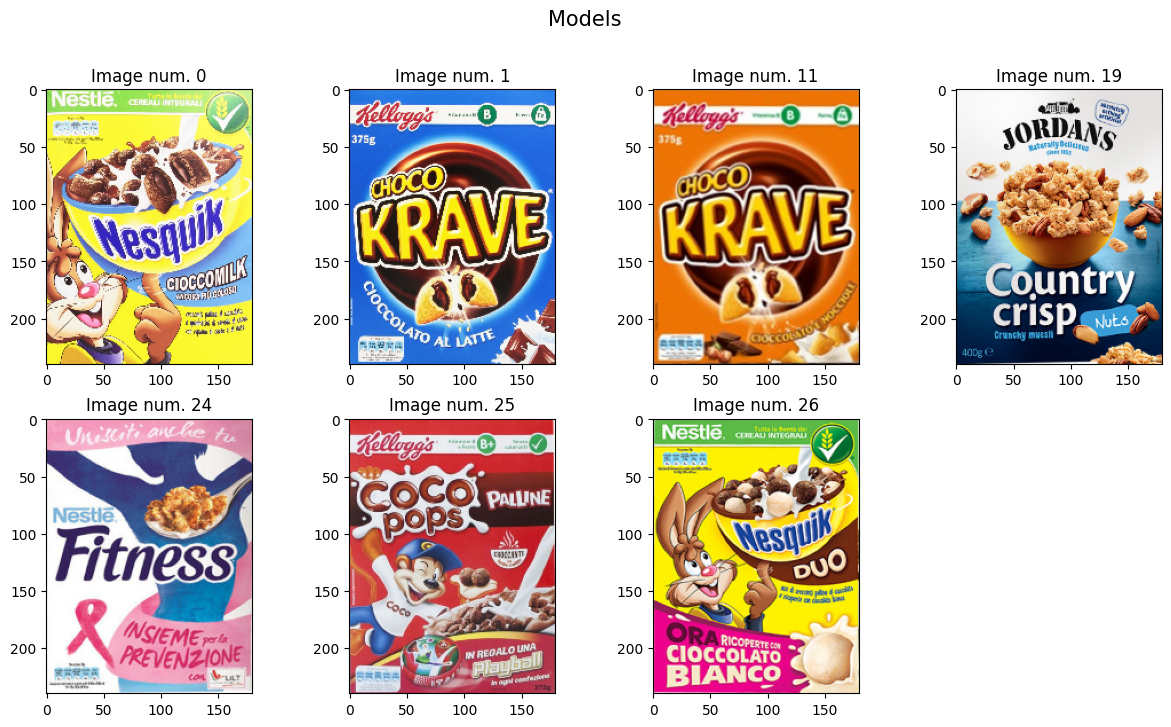

In [22]:
query_images = iut.load_images(base_path='models', step_directory='step_A',
                           image_indices=MODEL_REFERENCE_NUM, is_resized=True, target_model_dims=(180, 240))
iut.show_images(query_images, n_cols=4, title='Models')

### CHECK IF THIS WILL CHANGE FOR STEP B

In the image, we can observe several cereal box models, some of which are very similar to each other. In particular, models 1 and 11 show a significant difference in size despite being visually similar. The same applies to models 0 and 26.

Although SIFT (Scale-Invariant Feature Transform) is theoretically scale-invariant, in practice, such a large disparity in size can negatively impact the accuracy of feature matching. Therefore, it is advisable to resize all models to a consistent shape before applying SIFT to ensure more reliable and balanced descriptor extraction.

#### Loading scene images inspecting them

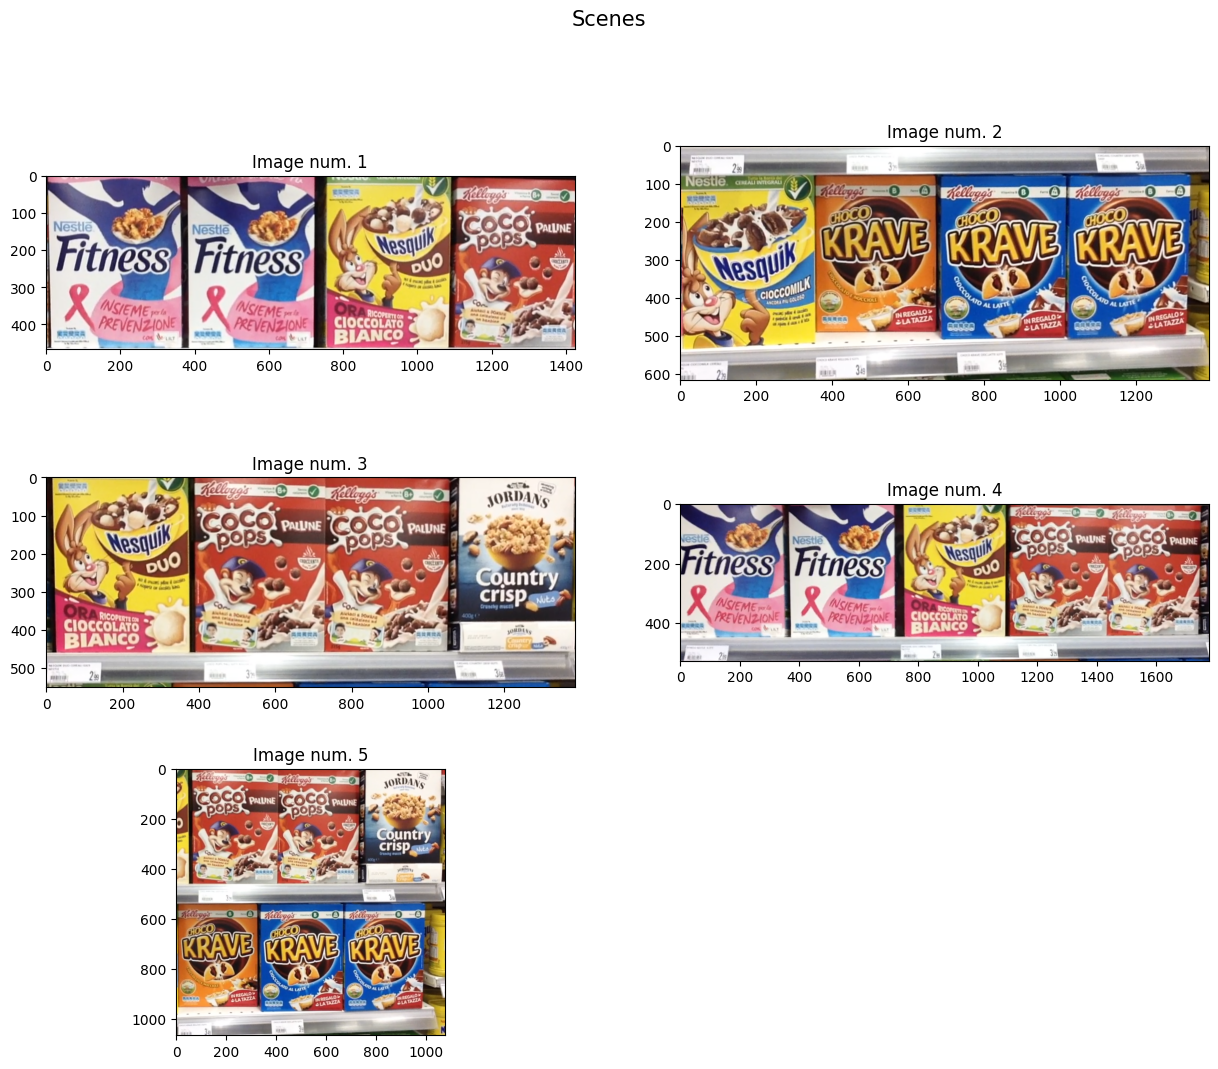

In [23]:
train_images = iut.load_images(base_path='scenes', step_directory='step_B')
iut.show_images(train_images, n_cols=2, title='Scenes')

We can observe the multiple instances in each of the scene images. In particular scene 5 has a two shelves whereas the other scenes consist of a single horizontal shelf. Also scenes 2,3,4 and 5 present the grey shelf line and the price tags which can be defined as distractors. 

## 2. Keypoints detection and description

In this section of the notebook we will define how the image keypoints and their descriptors will be handled:

1. First in the **section 2.1** I will define the functions that will allow to detect keypoints and their descriptor for each of the color channels of a given model/scene.
2. In the **section 2.2** i will employ this code to store in a dictionary all the dictionaries of the keypoints for each model/scene of the single RGB channels.
3. **COMPLETE ME**

### 2.1 Keypoint detection and description for each color channel


To improve the effectiveness of keypoint extraction, I chose to compute SIFT features separately on each RGB channel rather than converting the image to grayscale.  This decision was based on the fact that important structural or textural details can appear more clearly in individual color channels, depending on the image content. By processing each channel independently and then merging the keypoints, I will retain complementary information that would otherwise be lost in a grayscale transformation.

So a dictionary has been used to store the keypoints of each image, by having as key the intial for each of the three color channels. This has been handled by the `create_channel_dict` function.

In [24]:
def create_channel_dict(img: NDArray[np.uint8]) -> dict[str, NDArray[np.uint8]]:
    """Return a dictionary which contains the RGB channels

    Args:
        img (NDArray[np.uint8]): Input image in RGB format

    Returns:
        dict[str, NDArray[np.uint8]]: Dictionary containing the R, G, and B channels
    """
    r_channel, g_channel, b_channel = cv2.split(img)
    return {
        "R": r_channel,
        "G": g_channel,
        "B": b_channel
    }


### 2.2 Keypoint detection for each model



- I used the function defined in the previous cell, which computes the keypoints for each of the three color channels of a single image, to create the `extract_features_dict` function. This function returns a tuple containing two dictionaries: one storing all the keypoints dictionaries and the other storing the descriptors dictionaries for the three RGB channels.

- The keys for the inner dictionary are the color channel initials 
- The keys for the outer dictionary are the model/scenes indexes. 

- The two dictionaries contained in the tuple therefore contains the detected keypoints and their descriptors for each model and for each scene.

- Example output:
    ```python

    model_indexes = [0,1,11,19,24,25,26]

    keypoints_dict = (
        {  
            model_indexes[0]: {
                'R': [<cv2.KeyPoint 0x1>, <cv2.KeyPoint 0x2>],
                'G': [<cv2.KeyPoint 0x3>, <cv2.KeyPoint 0x4>],
                'B': [<cv2.KeyPoint 0x5>, <cv2.KeyPoint 0x6>]
            },
            model_indexes[1]: {
                'R': [<cv2.KeyPoint 0x7>, <cv2.KeyPoint 0x8>],
                'G': [<cv2.KeyPoint 0x9>, <cv2.KeyPoint 0x10>],
                'B': [<cv2.KeyPoint 0x11>, <cv2.KeyPoint 0x12>]
            }
            # ... more keys for each image id
        }

    descriptors_dict =
        {  
            model_indexes[0]: {
                'R': np.array([[ 1.,  2.,  3.], [ 4.,  5.,  6.]], dtype=np.float32),
                'G': np.array([[ 7.,  8.,  9.], [10., 11., 12.]], dtype=np.float32),
                'B': np.array([[13., 14., 15.], [16., 17., 18.]], dtype=np.float32)
            },
            model_indexes[1]: {
                'R': np.array([[21., 22., 23.], [24., 25., 26.]], dtype=np.float32),
                'G': np.array([[27., 28., 29.], [30., 31., 32.]], dtype=np.float32),
                'B': np.array([[33., 34., 35.], [36., 37., 38.]], dtype=np.float32)
            }
            # ... more keys for each image id
        }
    )

    ```

In [25]:
def extract_features_dict(
    images: dict[int, NDArray[np.uint8]],
    detector: cv2.Feature2D ) -> tuple[dict[int, dict[str, list[cv2.KeyPoint]]],
                dict[int, dict[str, NDArray[np.float32]]]]:

    """
    Extract keypoints and descriptors for each image and its RGB channels.

    This function processes a collection of images, extracting feature keypoints
    and descriptors for each image's red, green, and blue (RGB) channels using
    a specified OpenCV feature detector (e.g., SIFT, ORB). The extracted features
    are organized into dictionaries for easy access and analysis.

    Args:
        images (dict[int, NDArray[np.uint8]]):
            A dictionary where the keys are image IDs (integers) and the values
            are the corresponding images represented as NumPy arrays in uint8 format.
        detector (cv2.Feature2D):
            An OpenCV Feature2D object responsible for detecting keypoints and
            computing descriptors (e.g., cv2.SIFT_create()).

    Returns:
        tuple[dict[int, dict[str, list[cv2.KeyPoint]]], dict[int, dict[str, NDArray[np.float32]]]]:
            A tuple containing two dictionaries:

            - keypoints_dict: A dictionary mapping each image ID to another dictionary
              containing the keypoints for the RGB channels. The structure is:
              {image_id: {'R': [keypoints], 'G': [keypoints], 'B': [keypoints]}}.

            - descriptors_dict: A dictionary mapping each image ID to another dictionary
              containing the descriptors for the RGB channels. The structure is:
              {image_id: {'R': descriptors, 'G': descriptors, 'B': descriptors}}.

    Example:
        images = {
            1: cv2.imread("image1.jpg"),
            2: cv2.imread("image2.jpg")
        }
        detector = cv2.SIFT_create()
        keypoints_dict, descriptors_dict = extract_features_dict(images, detector)

    Notes:
        - The function assumes that the input images are in RGB format.
        - The `create_channel_dict` helper function is used to split each image
          into its RGB channels.
        - The `detector.detectAndCompute` method is called for each channel to
          extract the keypoints and descriptors.
    """

    keypoints_dict = {}
    descriptors_dict = {}

    for img_id, img in images.items():
        channels = create_channel_dict(img) # create a dictionary of channels

        keypoints_color_dict = {}
        descriptors_color_dict = {}

        for color_name, channel_img in channels.items():
            kp_color, des_color = detector.detectAndCompute(channel_img, None)
            keypoints_color_dict[color_name] = kp_color
            descriptors_color_dict[color_name] = des_color

        keypoints_dict[img_id] = keypoints_color_dict
        descriptors_dict[img_id] = descriptors_color_dict

    return keypoints_dict, descriptors_dict

The structure of the keypoints and descriptors dictionary is shown for clarity, but it will be re-computed inside the functions that will perform feature matching.

In [26]:
# Instantiate dictionaries containing keypoints for query and train images
sift = cv2.SIFT_create()
kp_query_dict, des_query_dict = extract_features_dict(query_images, sift)
kp_train_dict, des_train_dict = extract_features_dict(train_images, sift)

In [27]:
# The dictionaries keys are the model/scene number and they contain the keypoints/descriptors as values
# { id: { 'R': kp, 'G': kp, 'B': kp } }
print('\n- Model number keys: ', kp_query_dict.keys())
print('\n- Inspecting that the key structure is correct for model 0 keypoints: '
      , kp_query_dict[0].keys())

# Not printing the keypoints inner structure because it would have taken too much space


- Model number keys:  dict_keys([0, 1, 11, 19, 24, 25, 26])

- Inspecting that the key structure is correct for model 0 keypoints:  dict_keys(['R', 'G', 'B'])


In [28]:
# The dictionaries keys are the model/scene number and they contain the keypoints/descriptors as values
# { id: { 'R': des, 'G': des, 'B': des } }
print('\n- Scene number number keys: ', des_train_dict.keys())
print('\n- Inspecting that the key structure is correct for scene 1: ',des_train_dict[1].keys())
print('\n- Inspecting that the values structure is correct for scene 1: ',
        list(des_train_dict[1].values())[:2])


- Scene number number keys:  dict_keys([1, 2, 3, 4, 5])

- Inspecting that the key structure is correct for scene 1:  dict_keys(['R', 'G', 'B'])

- Inspecting that the values structure is correct for scene 1:  [array([[19., 75., 22., ...,  5.,  0.,  0.],
       [ 7.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ...,
       [ 1.,  0.,  0., ...,  0.,  0.,  0.],
       [ 1.,  4., 10., ...,  0.,  0.,  0.],
       [ 1.,  0.,  0., ...,  0.,  0.,  0.]], dtype=float32), array([[  0.,   0., 144., ...,   0.,   0.,   0.],
       [ 12.,  53.,   9., ...,   0.,   0.,   0.],
       [  0.,   0.,   0., ...,   0.,   0.,   3.],
       ...,
       [  4.,   4.,  36., ...,   0.,   0.,   0.],
       [  3.,   0.,   0., ...,   0.,   0.,   0.],
       [  0.,   2.,  62., ...,   0.,   0.,   1.]], dtype=float32)]


## 3. Feature matching

In this section I will attempt to find instances of the model images across the various scene images. 

1. The first step to achieve this is to instantiate the matching criterion. This will be achieved using an approximate but effective matcher: FLANN, which will be instantiated through the function `initialize_flann`.

2. Given that the problem is single instance we can employ the **Lowe** criterion,  which allows discarding incorrect matches by assuming that a match for a keypoint (**m**) is good if, the distance from m of the second best match (**n**), is greater than a certain value. This logic of filtering matches will be implemented by the function `filter_matches`.

4. This filtering function will be used inside `compute_matches_dict_single` which will return the matches that resepect the Lowe criterion for all the three color channels.

In [29]:
def initialize_flann():
    """
    Initializes the FLANN matcher with default parameters.

    Returns:
        cv2.FlannBasedMatcher: Instance of the FLANN Matcher.
    """
    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
    search_params = dict(checks=50)
    return cv2.FlannBasedMatcher(index_params, search_params)

> The function match_descriptors takes as input the lists containing the descriptors of a query image and a train image, and returns the list containing the matches found by the Flann-Based Matcher divided by color channel. This time, the Lowe's Ratio Test is not used because we do not want to keep only the best match found with knnMatch. Instead, we want to have access to the k best matches for a keypoint, as there might be multiple instances of a query object in a train image. However, this means that any incorrect matches are not filtered out. Nonetheless, this is not an issue because they will be implicitly discarded during the GHT phase (incorrect matches do not contribute to increasing a maximum in the accumulator array).

In [30]:


def filter_matches(matches: list[list[cv2.DMatch]]) -> list[cv2.DMatch]:

    """
    Filters false positives using Lowe's ratio test.

    This function accepts a match only if:
        - The distance of the best match (m) is significantly smaller than the distance of the second-best match (n).
        - Specifically, m.distance < 0.7 * n.distance.

    Parameters:
        matches (list[list[cv2.DMatch]]): List of pairs (k=2) obtained from knnMatch(..., k=2).

    Returns:
        list[cv2.DMatch]: List of accepted matches that pass the ratio test.
    """


    good_matches = []
    for m, n in matches:
        if m.distance < 0.7 * n.distance:
            # print('Query idx', m.queryIdx)
            good_matches.append(m)

    return good_matches

In [31]:
def compute_matches_dict_single(
    des_query_dict_single: Dict[str, NDArray[np.float32]],
    des_train_dict_single: Dict[str, NDArray[np.float32]],
    flann_init_func: Callable[[], cv2.FlannBasedMatcher],
    filter_func: Callable[[List[List[cv2.DMatch]]], List[cv2.DMatch]]
    ) -> Dict[str, List[cv2.DMatch]]:

    """
    Performs matching (k=2) and filtering (ratio test) between the descriptors
    of the 'model_id' and those of the 'scene_id', channel by channel ('R', 'G', 'B').

    Returns a dictionary:
        { 'R': [...], 'G': [...], 'B': [...] } containing the "good" matches for each channel.

    Parameters:
        des_query_dict_single:
            {
            'R': des_R_query, 'G': des_G_query, 'B': des_B_query
            }

        des_train_dict_single:
            {
            'R': des_R_train, 'G': des_G_train, 'B': des_B_train
            }

        flann_init_func (Callable): Function that creates and returns a new FLANNBasedMatcher.
        filter_func (Callable): Function that filters the k=2 matches (e.g., ratio test).

    Returns:
        good_matches_channels (Dict[str, List[cv2.DMatch]]):
            A dictionary containing the good matches for each channel:
            { 'R': [...], 'G': [...], 'B': [...] }
    """

    # Output dictionary for the "good" matches for each channel.
    good_matches_channels = {}

    # Iterate over each channel ('R', 'G', 'B').
    for color_name, des_query in des_query_dict_single.items():

        # Retrieve the corresponding descriptors in the scene.
        des_train = des_train_dict_single[color_name]

        # Initialize the FLANN matcher.
        flann_matcher = flann_init_func()

        # 🚨 Changed from step_A: Perform knnMatch with k=3.
        matches = flann_matcher.knnMatch(des_query, des_train, k=2)

        # Apply the ratio test or other filtering.
        good = filter_func(matches)

        good_matches_channels[color_name] = good

    return good_matches_channels

## 4. Object identification

In this section I will attempt at finally identifying the model boxes inside the scenes.

1. First I will stack the coordinates of the good matches from the the three channels into a single array and then compute the homography by exploiting the RANSAC algorithm provided by `opencv`. This is implemented in the `compute_homography` function. 
   1. This function takes as input the keypoints found in the query and train images and the matches obtained with the `compute_matches_dict_single` function and returns the homography calculated using the findHomography function of OpenCV (which uses RANSAC to obtain a robust homography).
   
2. I will combine the functions we defined in the previous sections of this notebook and the data structures that were described. In particular the function `object_retrieve` will: 
   1. Take the descriptors and keypoints dictionaries obtained from the function `compute_matches_dict_single` and from those it will check with a criterion if the number of good matches is enough to identify a model in a scene, so it will determine if the number of keypoints matches are enough to determine that the instance of a model is found in the scene.  
   
   2. If the number of matches exceeds the criterion for establishing a match, then the homography and the perspective transformation of the model's corners to scene are computed. In this context the criterion is important because we have keypoints for three channels therefore as input to the function i use the *minimum_avg_number* of matches per channel (in the instantion of the code in the main function I chose 75 per channel) and then we multiply it by the number of channels. This number is compared with the sum of keypoint matches across all three channels to determine if the match is found or if the number of found keypoints is below the threshold then, the object is considered not found in the scene.


In [32]:
def compute_homography(
    kp_query_dict_single: Dict[str, List[cv2.KeyPoint]],
    kp_train_dict_single: Dict[str, List[cv2.KeyPoint]],
    good_matches_channels: Dict[str, List[cv2.DMatch]]) -> NDArray[np.float64]:
    """
    Compute a robust homography matrix that maps points from the query image to the train image using
    keypoints detected in each color channel. For each channel ('R', 'G', 'B'), the function extracts
    the matching keypoints based on the provided good matches, stacks their coordinates, and then uses the
    RANSAC algorithm to compute a homography matrix that best aligns the query and train points.

    Args:
        kp_query_dict_single (Dict[str, List[cv2.KeyPoint]]): Keypoints for the query image organized
            by color channels.
        kp_train_dict_single (Dict[str, List[cv2.KeyPoint]]): Keypoints for the train image organized
            by color channels.
        good_matches_channels (Dict[str, List[cv2.DMatch]]): Filtered matches for each color channel
            obtained after applying Lowe's ratio test.

    Returns:
        NDArray[np.float64]: A 3x3 homography matrix computed using RANSAC.
    """

    src_array = np.array([])
    dst_array = np.array([])

    # Retireve the matching keypoints for each channel
    for color in kp_train_dict_single.keys():


        src_pts = np.float32([kp_query_dict_single[color][m.queryIdx].pt for m in good_matches_channels[color]]).reshape(-1, 1, 2)
        dst_pts = np.float32([kp_train_dict_single[color][m.trainIdx].pt for m in good_matches_channels[color]]).reshape(-1, 1, 2)



        if src_array.size: # if the src array has a size, append the new points
            # Append the new points to the existing array
            src_array = np.vstack([src_array, src_pts])
        else:
            src_array = src_pts # if the src array is empty, assign the src_pts to it

        if dst_array.size:
            dst_array = np.vstack([dst_array, dst_pts])
        else:
            dst_array = dst_pts

    print('Shape <src_array|src_pts_matches>: ', src_array.shape)

    # compute the homography matrix using RANSAC on the stacked keypoints
    M, _ = cv2.findHomography(src_array, dst_array, cv2.RANSAC, 5.0)
    return M

In [33]:

x = kp_query_dict[0]['R'][0].pt[0]
y = kp_query_dict[0]['R'][0].pt[1]
size = kp_query_dict[0]['R'][0].size

print(x, y , size)

4.733487606048584 213.9364013671875 3.0438411235809326


In [34]:
def object_retrieve(flann_init_func: Callable,
                    filter_func: Callable,
                    img_query,
                    kp_query_dict_single: dict[str, NDArray[np.float32]],
                    des_query_dict_single: dict[str, NDArray[np.float32]],
                    kp_train_dict_single: dict[str, NDArray[np.float32]],
                    des_train_dict_single: dict[str, NDArray[np.float32]],
                    min_match_count_single_channel: int):

    """
    Retrieve the object in the train image using feature matching and homography estimation.

    The function computes good matches for each channel between the query and train images. If the total
    number of good matches exceeds a threshold (determined by min_match_count per channel), it calculates
    the homography transformation and projects the corners of the query image into the train image.

    Args:
        flann_init_func (Callable): Function to initialize the FLANN matcher.
        filter_func (Callable): Function to filter the matches.
        img_query: The query image.
        kp_query_dict_single (dict[str, NDArray[np.float32]]): Keypoints of the query image per channel.
        des_query_dict_single (dict[str, NDArray[np.float32]]): Descriptors of the query image per channel.
        kp_train_dict_single (dict[str, NDArray[np.float32]]): Keypoints of the train image per channel.
        des_train_dict_single (dict[str, NDArray[np.float32]]): Descriptors of the train image per channel.
        min_match_count_single_channel (int): Minimum required matches per channel.

    Returns:
        np.ndarray: The projected corners of the query image in the train image if sufficient matches are found.
        None: If the computed total matches do not exceed the threshold.
    """

    # 1. Retrieve matches
    good_matches_channels = compute_matches_dict_single(
        des_query_dict_single,
        des_train_dict_single,
        flann_init_func,
        filter_func)

    # Count the total number of matches across all channels
    num_matches_all_channels = sum(len(matches) for matches in good_matches_channels.values())

    # 2. If number of matches exceeds the threshold, compute the homography

    # Threshold is obtained as the min_match_count per single channel times the number of channels
    if num_matches_all_channels > min_match_count_single_channel * len(good_matches_channels):
        homography = compute_homography(
            kp_query_dict_single,
            kp_train_dict_single,
            good_matches_channels)

        height, width = img_query.shape[:2]

        # Corners of the query image (model)
        pts = np.float32([
            [0, 0],             # top-left corner
            [0, height - 1],    # bottom-left corner
            [width - 1, height - 1],  # bottom-right corner
            [width - 1, 0]      # top-right corner
        ]).reshape(-1, 1, 2)

        # Projecting the corners into the train image
        dst = cv2.perspectiveTransform(pts, homography)

        return dst

    # Return None if no valid matches are found
    else:
        return None

## 5. Displaying bounding boxes and printing matching coordinates

In this section I will deal with the computation of the bounding box and of the coordinates of found boxes, putting together all the functions developed until this section of the notebook. 

1. Before the main function it is defined an utility function that is important because it encapsulates the printing of center coordinates and dimension of the found boxes. It takes as input the box features that will be computed inside the `main` function and the query and train images in order to correctly display the output and it returns the scene image with the all the bounding boxes drawn for the query images instances found inside the train images. 

2. The `main` function will make use of all the other components that were defined in this notebook:

   - It works by performing a loop first on all the scenes and then checking for each scene, if the model that has been selected is present in the said scene. If the model is found as per the criteria defined in the notebook the bounding box will be drawn and the code will print the requested output as per the project specification.

   - An important thing to note is the usage of the function `compute_aligned_rectangle` that is defined in the module **`bounding_box_utils`**.  This function approximates the detected object's bounding box with a rectangle to compute its center and dimensions (width and height). It accepts the points of the bounding box (obtained via the computed homography) and returns the rectangle's vertices, its width, height, and center. 
     - It is important because it defines limits for the position of the bounding box's points. If not constrained, they can exceed the image borders and also the polyline that connects them is not a rectangle. Therefore it also ensures the rectangular shape of the bounding box, especially for the choco pops model which would often time be skewed and not be a closed shape.

   - The instructions are interleaved with some utility code to make it more distinguishible which scene is being currently analyzed

   - Lastly the function will display the required information for the position of the centers of the boxes and their dimensions, it will draw the bounding box and, at the center of each model found in the scene, it will display the number of the found model.

In [35]:
def process_and_draw_instances(boxes_info: list, query_images: dict[str, np.ndarray],
                            img_train: np.ndarray) -> np.ndarray:
    """
    Process and draw bounding boxes for detected instances in the train image.

    Args:
        boxes_info (list): List of detected instances information.
        query_images (dict): Dictionary of query images.
        img_train (np.ndarray): Train image to draw bounding boxes on.

    Returns:
        np.ndarray: The train image with drawn bounding boxes.
    """

    # Draw on a copy to preserve the original image
    img_train_bounding = img_train.copy()

    for instances_single_model, query_name in zip(boxes_info, query_images.keys()):
        num_instance = 0
        found_instances = len(instances_single_model)
        print(f"Product {query_name} - {found_instances} instance(s) found:")

        for instance_info in instances_single_model:
            # Extract box info (rectangle, box_width, box_height, box_center)
            rectangle = instance_info[0]
            box_width = instance_info[1]
            box_height = instance_info[2]
            box_center = instance_info[3]

            # Draw the rectangle on the image
            img_train_bounding = cv2.polylines(
                img_train_bounding,
                pts=[np.int32(rectangle)],
                isClosed=True,
                color=(0, 255, 0),
                thickness=4,
                lineType=cv2.LINE_AA
            )

            # Place the product number at the center using the helper function
            text_str = str(query_name)
            img_train_bounding = bb.draw_text_with_background(
                img_train_bounding,
                text_str,
                box_center,
                font=cv2.FONT_HERSHEY_SIMPLEX,
                font_scale=2.75,
                thickness=8,
                bg_color=(255, 255, 255),
                opacity=0.5,
                text_color=(0, 220, 0) # more readable shade of green
            )

            num_instance += 1

            print(f"\tInstance {num_instance} {{position: ({box_center[0]}, {box_center[1]}), width: {box_width}px, height: {box_height}px}}")

    print()
    return img_train_bounding


In [36]:
def main(min_count: int , query_images: dict[int, np.ndarray],
            train_images: dict[int, np.ndarray]) -> None:
    """
    Iterate over each scene and model to perform object detection and compute bounding boxes.

    This function extracts features from both the query (model) and train (scene) images, then for each scene,
    it matches each model against the scene using the object_retrieve function. If a match is successful based on
    the minimum match threshold (min_count per channel), it collects positional information of the current detected model in the scene.
    Finally, it draws bounding boxes on the train image and displays the results.

    Args:
        min_count (int): Minimum number of matches required per channel to consider a valid detection.
        query_images (dict[int, np.ndarray]): Dictionary mapping model identifiers to their corresponding
            query image arrays.
        train_images (dict[int, np.ndarray]): Dictionary mapping scene identifiers to their corresponding
            train image arrays.

    Returns:
        None
    """

    # Extract features for query and train images
    kp_query_dict_full, des_query_dict_full = extract_features_dict(query_images, sift)
    kp_train_dict_full, des_train_dict_full = extract_features_dict(train_images, sift)

    separator = '*****'

    for scene_id in train_images.keys():

        boxes_info = []  # List of lists of tuples: (box_center, box_width, box_height, dst)
        print(f'🖼️ Analysis of scene: {scene_id}\n')
        print(f"{separator*20}\n")

        img_train = train_images[scene_id]

        kp_train_dict_single = kp_train_dict_full[scene_id]
        des_train_dict_single = des_train_dict_full[scene_id]

        for model_id in query_images.keys():

            # Contains spatial informations for all the instances of the current model found in the scene
            instances_single_model = []

            img_query = query_images[model_id]

            kp_query_dict_single = kp_query_dict_full[model_id]
            des_query_dict_single = des_query_dict_full[model_id]

            # Attempt to retrieve the object (returns transformed corner points if found)
            dst = object_retrieve(
                initialize_flann,
                filter_matches,
                img_query,
                kp_query_dict_single,
                des_query_dict_single,
                kp_train_dict_single,
                des_train_dict_single,
                min_count
            )

            if dst is not None:
                # Compute the rectangle geometry from the corner points
                rectangle, box_width, box_height, box_center = bb.compute_aligned_rectangle(dst, img_train.shape)

                # Pack the instance information
                instance_info = (rectangle, box_width, box_height, box_center)
                instances_single_model.append(instance_info)

            boxes_info.append(instances_single_model)

        # Draw all detected instances and show image
        img_train_bounding = process_and_draw_instances(boxes_info, query_images, img_train)

        # Display the image with bounding boxes
        plt.figure(figsize=(12, 6), dpi=125)
        plt.imshow(img_train_bounding)
        plt.title(f'Found boxes for scene {scene_id}')
        plt.show()

        print(f'🔬 Completed analysis of scene: {scene_id}\n')
        # print(f"{separator*20}\n")

## 6. Results computations

In [ ]:
main(min_count=75, query_images=query_images, train_images=train_images)

### Results summary